In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path="malgun.ttf"
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

### 전세/월세 기준 데이터 프레임 생성 함수

In [3]:
def rent(filename):
    file=filename
    data=pd.read_excel(file, header=16)
    
    data['계약년월'] = pd.to_datetime(data['계약년월'], format='%Y%m')
    monthly = data[data['전월세구분']=='월세']
    
# 월세 : month_df 에 컬럼 추가 후 시군구 컬럼에서 동구만 추출
    month_df = monthly[['시군구', '전용면적(㎡)', '계약년월','전월세구분','월세(만원)', '건축년도' ]]
    month_df['시군구']=month_df['시군구'].apply(lambda v : v.split()[1])
    month_df = month_df[month_df['시군구']!='군위군']
    month_df = month_df.drop(columns='전월세구분', axis=1)

# 전세 : annually_df 에 컬럼 추가 후 시군구 컬럼에서 동구만 추출    
    annually = data[data['전월세구분']=='전세']
    annually_df = annually[['시군구','전용면적(㎡)', '계약년월','전월세구분','보증금(만원)', '건축년도' ]]
    annually_df['시군구']=annually['시군구'].apply(lambda v : v.split()[1])
    annually_df['보증금(만원)'] = annually_df['보증금(만원)'].apply(lambda x:int(x.replace(',', '')))
    annually_df = annually_df[annually_df['시군구']!='군위군']
    annually_df = annually_df.drop(columns='전월세구분', axis=1)

    
    return month_df, annually_df

### 아파트 전세 데이터프레임에서 평당금액 컬럼을 추가한 데이터프레임 생성 함수

In [58]:
def average_amount_junse(filename):
    file=filename
    data=pd.read_excel(file, header=16)

    annually = data[data['전월세구분']=='전세']
    annually_df = annually[['시군구','전용면적(㎡)', '계약년월','전월세구분','보증금(만원)', '건축년도' ]]
    annually_df['시군구']=annually['시군구'].apply(lambda v : v.split()[1])
    annually_df['보증금(만원)'] = annually_df['보증금(만원)'].apply(lambda x:int(x.replace(',', '')))
    annually_df = annually_df[annually_df['시군구']!='군위군']
    annually_df = annually_df.drop(columns='전월세구분', axis=1)
    df = annually_df[['시군구','전용면적(㎡)','보증금(만원)', '건축년도' ]]
    df['평당금액']=df['보증금(만원)']/df['전용면적(㎡)']
    df_sorted = df.sort_index(ascending=True)
    test_list=df_sorted['건축년도'].unique().tolist()
    test_list=sorted(test_list)[:]
    df_sorted=df_sorted[df_sorted['건축년도'].isin(test_list)]
    df_sorted['평당금액_평균'] = df_sorted.groupby('건축년도')['평당금액'].transform('mean')
    new_df=df_sorted[['건축년도', '평당금액_평균']]
    new_df= new_df.drop_duplicates().reset_index(drop=True)
    new_df['건축년도']=sorted(new_df['건축년도'])
    new_df=new_df.set_index('건축년도')
    new_df.rename(columns={'평당금액_평균':df.iloc[0, 0]}, inplace=True)
    
    return new_df

### 시군구별 아파트 전세 데이터프레임 병합 함수

In [59]:
def merge_data_junse():
    jungu_df=average_amount_junse('대구광역시_아파트전월세(중구).xlsx')
    dongu_df=average_amount_junse('대구광역시_아파트전월세(동구).xlsx')
    soosung_df=average_amount_junse('대구광역시_아파트전월세(수성구).xlsx')
    seogu_df=average_amount_junse('대구광역시_아파트전월세(서구).xlsx')
    bookgu_df=average_amount_junse('대구광역시_아파트전월세(북구).xlsx')
    dalseogu_df=average_amount_junse('대구광역시_아파트전월세(달서구).xlsx')
    dalsunggun_df=average_amount_junse('대구광역시_아파트전월세(달성군).xlsx')
    namgu_df=average_amount_junse('대구광역시_아파트전월세(남구).xlsx')
    
    merged_dfs = [jungu_df, dongu_df, seogu_df, bookgu_df, dalseogu_df,namgu_df, soosung_df, dalsunggun_df ]
    merged_df = pd.concat(merged_dfs, axis=1, sort=True).fillna(0)
    
    df_replaced = merged_df.replace(0, np.nan)
    df_filled = df_replaced.fillna(method='ffill')
    
    selected_rows = df_filled.iloc[-7:]
    return selected_rows
    

In [63]:
selected_rows=merge_data_junse()
selected_rows

C:\Users\LG\anaconda3\envs\MY_PYTHON\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\LG\AppData\Local\Temp\ipykernel_10052\181943951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annually_df['시군구']=annually['시군구'].apply(lambda v : v.split()[1])
C:\Users\LG\AppData\Local\Temp\ipykernel_10052\181943951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

,중구,동구,서구,북구,달서구,남구,수성구,달성군
건축년도,,,,,,,,
2017,72.694230,127.721940,228.406923,284.389581,175.965648,248.222509,248.823995,298.567785
2018,297.901751,146.619842,228.406923,317.044593,207.036712,251.452967,216.994283,62.367616
2019,297.901751,146.619842,228.406923,149.543835,335.721193,239.665705,239.755959,193.474599
2020,399.569485,158.283523,228.406923,270.317738,261.361351,283.723331,404.219257,209.371076
2021,268.446588,270.651918,228.406923,171.816431,328.039963,191.184280,209.848909,134.218146
2022,334.284357,177.109440,192.828048,171.816431,288.165989,244.853544,335.355806,124.624710
2023,211.982924,139.311044,245.442839,149.113501,191.073756,209.515404,230.269674,219.071839


### 시군구별 아파트 전세 건축년도 당 평당금액 평균 그래프 시각화

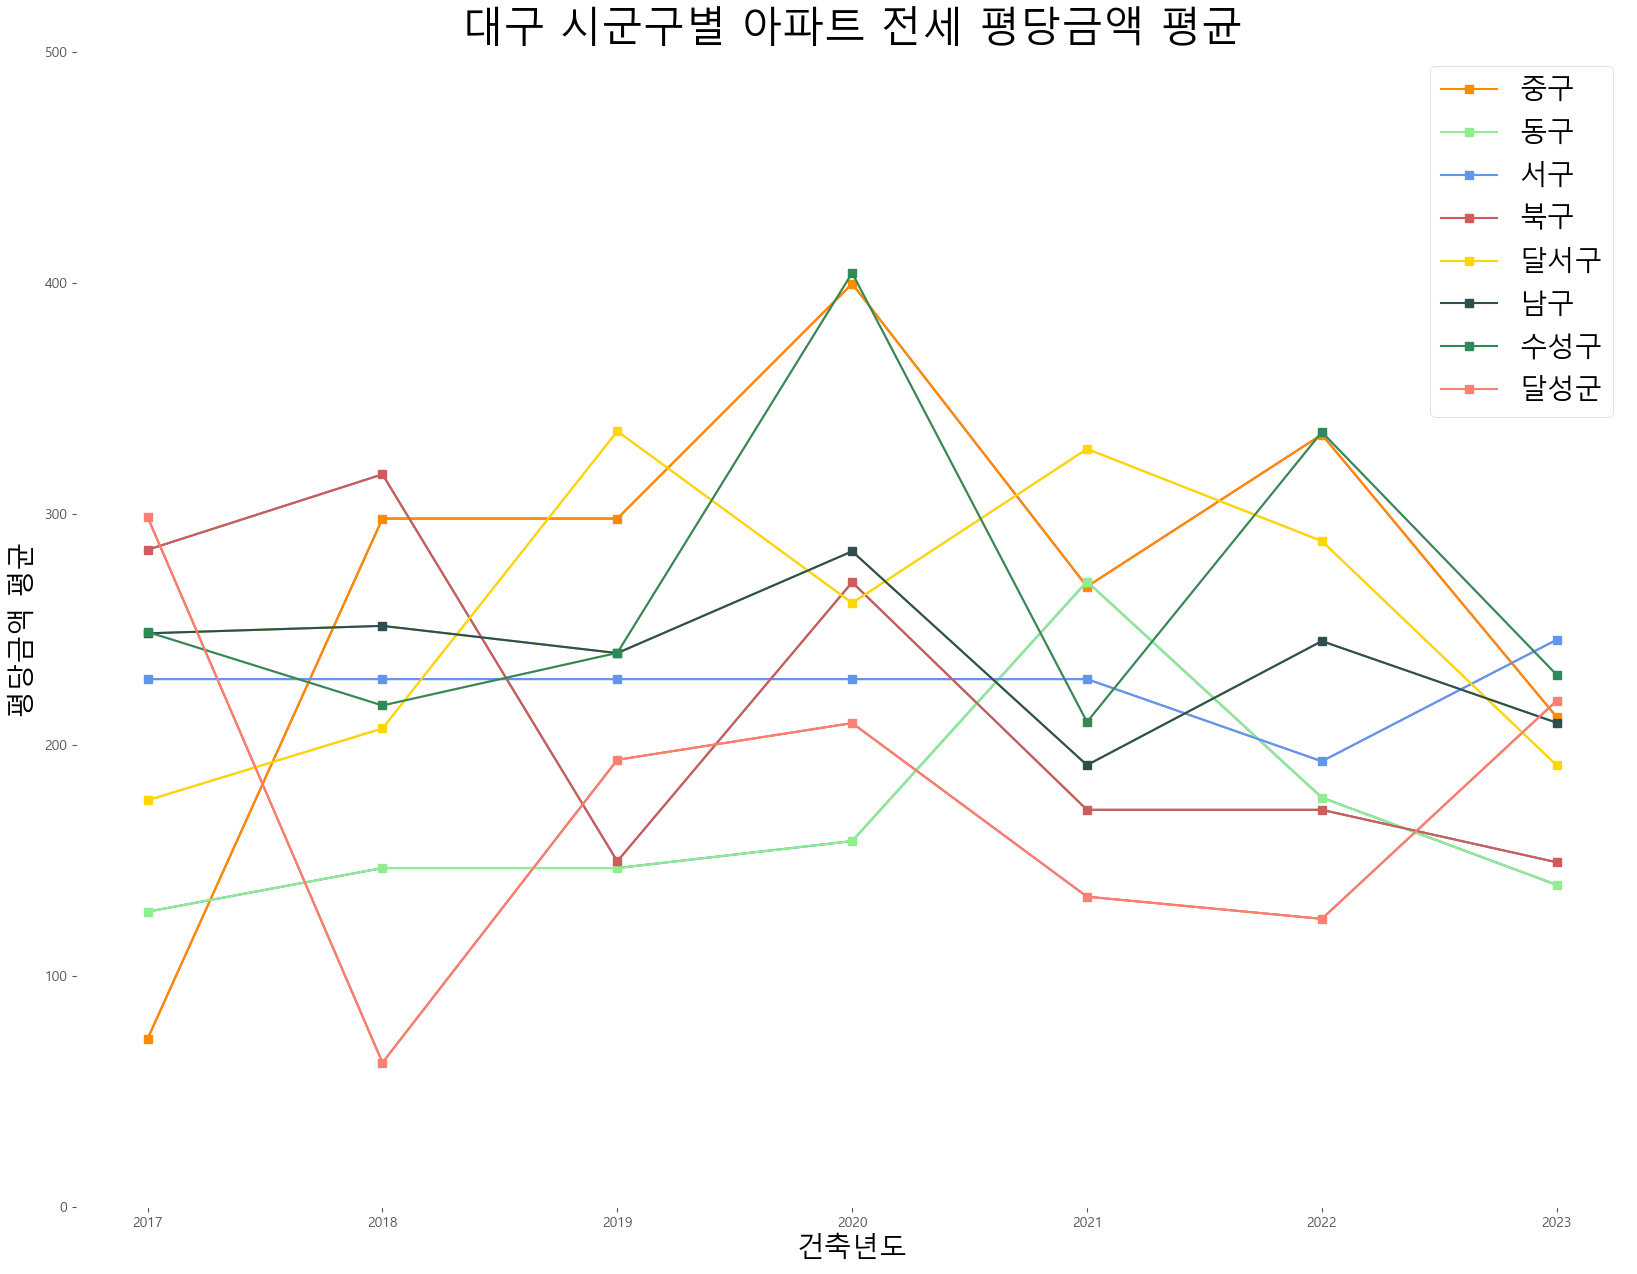

In [69]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(selected_rows.index, selected_rows[['중구', '동구', '서구', '북구', '달서구', '남구', '수성구', '달성군']])

ax = plt.gca()  # 현재 축 가져오기
# ax.spines['top'].set_visible(False)  # 상단 라인 제거
# ax.spines['right'].set_visible(False)  # 오른쪽 라인 제거
ax.spines['bottom'].set_linestyle('--')  # x축 라인 스타일 설정
ax.spines['left'].set_linestyle('--')  # y축 라인 스타일 설정



# selected_columns = ['중구', '동구', '서구', '북구', '달서구', '남구', '수성구', '달성군']
# selected_rows[selected_columns].plot(kind='line')

plt.plot(selected_rows.index, selected_rows['중구'], label='중구', marker='s', color='darkorange')
plt.plot(selected_rows.index, selected_rows['동구'], label='동구', marker='s', color='lightgreen')
plt.plot(selected_rows.index, selected_rows['서구'], label='서구', marker='s', color='cornflowerblue')
plt.plot(selected_rows.index, selected_rows['북구'], label='북구', marker='s', color='indianred')
plt.plot(selected_rows.index, selected_rows['달서구'], label='달서구', marker='s', color='gold')
plt.plot(selected_rows.index, selected_rows['남구'], label='남구', marker='s', color='darkslategrey')
plt.plot(selected_rows.index, selected_rows['수성구'], label='수성구', marker='s', color='seagreen')
plt.plot(selected_rows.index, selected_rows['달성군'], label='달성군', marker='s', color='salmon')

plt.legend(loc='upper right', fontsize=20)
plt.title('대구 시군구별 아파트 전세 평당금액 평균', fontsize=30)
plt.xlabel('건축년도', color='black', fontsize=20)
plt.ylabel('평당금액 평균', color='black', fontsize=20)
plt.ylim(0,500)
# plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

